In [12]:
%load_ext autoreload
%autoreload 2

import pickle

from config import Config

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import TABLEAU_COLORS

import numpy as np
from utility import format_decomp_name, format_dataset_name, format_algorithm_name

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
RESULTS_EXP_3_FOLDER = "results/experiment_3/"
RESULTS_EXP_4_FOLDER = "results/experiment_4/"
c = Config()
algorithm_names = c.algorithm_names_generic_input

In [14]:
evaluation_metric = "mae"
all_errors_exp3 = np.full((len(algorithm_names),len(c.dataset_names),len(c.decomp_input_names), len(c.metrics)), -1.0)
all_errors_exp4 = np.full((len(algorithm_names),len(c.dataset_names),len(c.decomp_input_names), len(c.metrics)), -1.0)

for i, algorithm in enumerate(algorithm_names):
    for j, dataset in enumerate(c.dataset_names):
        folder = RESULTS_EXP_3_FOLDER + algorithm + "/"
        with open(folder + dataset + ".pkl", "rb") as file:
            errors = pickle.load(file)
            for k, decomp in enumerate(c.decomp_input_names):
                for l, metric in enumerate(c.metrics):
                    if decomp not in errors.keys():
                        # trend-seasonality doesnt work for all datasets (due to non-existant period)
                        all_errors_exp3[i,j,k,l] = None
                        continue
                    all_errors_exp3[i,j,k,l] = errors[decomp][metric]
        folder = RESULTS_EXP_4_FOLDER + algorithm + "/"
        with open(folder + dataset + ".pkl", "rb") as file:
            errors = pickle.load(file)
            for k, decomp in enumerate(c.decomp_input_names):
                for l, metric in enumerate(c.metrics):
                    if decomp not in errors.keys():
                        # trend-seasonality doesnt work for all datasets (due to non-existant period)
                        all_errors_exp4[i,j,k,l] = None
                        continue
                    all_errors_exp4[i,j,k,l] = errors[decomp][metric]
mae_exp3 = all_errors_exp3[...,c.metrics.index(evaluation_metric)]
mae_exp4 = all_errors_exp4[...,c.metrics.index(evaluation_metric)]

In [15]:
error_reduction_exp3 = 100 * -(mae_exp3[:,:,1:] - mae_exp3[:,:,:1]) / mae_exp3[:,:,:1]
error_reduction_exp4 = 100 * -(mae_exp4[:,:,1:] - mae_exp4[:,:,:1]) / mae_exp4[:,:,:1]

In [16]:
print("\\begin{table}[h]")
print("\centering")
print("\caption{Error reduction from using no decomposition for the generic, decomposition-adapted models under a fixed-input setup.}")
print("\\begin{tabular}{c|c", end="")
for _ in range(len(c.dataset_names)):
    print("|c",end="")
print("}")
print(" &",end="")  
for dataset in c.dataset_names:
    print(f" & {format_dataset_name(dataset,long=False)}",end="")
print("\\\\")
print("\midrule")

rows = []
for algorithm in c.algorithm_names_generic_input:
    rows.append("\multirow{"+str(len(c.decomp_input_names)-1)+"}{*}{\\rotatebox{90}{" + format_algorithm_name(algorithm) + "}} & " + format_decomp_name(c.decomp_input_names[1],long=False) + " ")
    for decomp in c.decomp_input_names[2:]:
        rows.append(" & " + format_decomp_name(decomp,long=False) + " ")

for i, dataset in enumerate(c.dataset_names):
    means = error_reduction_exp3[:,i,:]
    mean = np.nanmean(means,axis=1)
    max_indices = np.nanargmax(means,axis=1)
    for j, name in enumerate(c.algorithm_names_generic_input):
        for k, decomp in enumerate(c.decomp_input_names[1:]):
            if np.isnan(means[j][k]):
                rows[(j*(len(c.decomp_input_names)-1))+k] += "& - "
            elif k == max_indices[j]:
                rows[(j*(len(c.decomp_input_names)-1))+k] += "& \\textbf{" + "{:.2f}".format(means[j][k]) + "}\% "
            else:
                rows[(j*(len(c.decomp_input_names)-1))+k] += "& {:.2f}\% ".format(means[j][k])

for i, row in enumerate(rows):
    print(row + "\\\\")
    if i > 0 and (i+1) % (len(c.decomp_input_names)-1) == 0 and i < len(rows)-1:
        print("\midrule")

print("\end{tabular}")
print("\label{tab:error_reduction_generic_models_fixed_input}")
print("\end{table}")

\begin{table}[h]
\centering
\caption{Error reduction from using no decomposition for the generic, decomposition-adapted models under a fixed-input setup.}
\begin{tabular}{c|c|c|c|c|c|c|c|c|c|c|c|c}
 & & M4(H) & Weather & Trans. & CIF & Rain & M4(Y) & Covid & ETTh1 & Exch. & Illness & Walmart\\
\midrule
\multirow{6}{*}{\rotatebox{90}{\texttt{G-Linear}}} & MA & 2.76\% & -0.99\% & -0.75\% & 12.97\% & \textbf{0.68}\% & 0.50\% & \textbf{-1.71}\% & 0.35\% & 0.18\% & -1.18\% & 0.53\% \\
 & TS & -1.60\% & - & -1.02\% & - & -2.69\% & - & - & 0.39\% & -8.22\% & - & - \\
 & STL & 5.08\% & - & -1.39\% & - & -6.16\% & - & - & 0.09\% & -3.05\% & - & - \\
 & F(BL) & 5.78\% & \textbf{-0.43}\% & \textbf{-0.43}\% & 20.05\% & -4.61\% & 4.89\% & -17.06\% & 0.64\% & -6.26\% & -4.53\% & \textbf{2.32}\% \\
 & F(k) & 4.95\% & -0.67\% & -1.32\% & 14.79\% & -5.31\% & 4.28\% & -2.11\% & -1.11\% & -2.40\% & -1.68\% & 0.23\% \\
 & Wav & \textbf{6.91}\% & -0.45\% & -0.66\% & \textbf{21.89}\% & -3.61\% & \textbf{6.5

In [17]:
print("\\begin{table}[h]")
print("\centering")
print("\caption{Error reduction from using no decomposition for the generic, decomposition-adapted models under an expanding-input setup.}")
print("\\begin{tabular}{c|c", end="")
for _ in range(len(c.dataset_names)):
    print("|c",end="")
print("}")
print(" &",end="")  
for dataset in c.dataset_names:
    print(f" & {format_dataset_name(dataset,long=False)}",end="")
print("\\\\")
print("\midrule")

rows = []
for algorithm in c.algorithm_names_generic_input:
    rows.append("\multirow{"+str(len(c.decomp_input_names)-1)+"}{*}{\\rotatebox{90}{" + format_algorithm_name(algorithm) + "}} & " + format_decomp_name(c.decomp_input_names[1],long=False) + " ")
    for decomp in c.decomp_input_names[2:]:
        rows.append(" & " + format_decomp_name(decomp,long=False) + " ")

for i, dataset in enumerate(c.dataset_names):
    means = error_reduction_exp4[:,i,:]
    mean = np.nanmean(means,axis=1)
    max_indices = np.nanargmax(means,axis=1)
    for j, name in enumerate(c.algorithm_names_generic_input):
        for k, decomp in enumerate(c.decomp_input_names[1:]):
            if np.isnan(means[j][k]):
                rows[(j*(len(c.decomp_input_names)-1))+k] += "& - "
            elif k == max_indices[j]:
                rows[(j*(len(c.decomp_input_names)-1))+k] += "& \\textbf{" + "{:.2f}".format(means[j][k]) + "}\% "
            else:
                rows[(j*(len(c.decomp_input_names)-1))+k] += "& {:.2f}\% ".format(means[j][k])

for i, row in enumerate(rows):
    print(row + "\\\\")
    if i > 0 and (i+1) % (len(c.decomp_input_names)-1) == 0 and i < len(rows)-1:
        print("\midrule")

print("\end{tabular}")
print("\label{tab:error_reduction_generic_models_expanding_input}")
print("\end{table}")

\begin{table}[h]
\centering
\caption{Error reduction from using no decomposition for the generic, decomposition-adapted models under an expanding-input setup.}
\begin{tabular}{c|c|c|c|c|c|c|c|c|c|c|c|c}
 & & M4(H) & Weather & Trans. & CIF & Rain & M4(Y) & Covid & ETTh1 & Exch. & Illness & Walmart\\
\midrule
\multirow{6}{*}{\rotatebox{90}{\texttt{G-Linear}}} & MA & 2.83\% & -0.82\% & -0.68\% & -12.80\% & \textbf{0.84}\% & 0.49\% & 2.38\% & 0.37\% & 0.50\% & \textbf{-1.18}\% & \textbf{4.10}\% \\
 & TS & -0.70\% & - & -0.45\% & - & -16.52\% & - & - & -3.96\% & -35.71\% & - & - \\
 & STL & \textbf{6.73}\% & - & -1.35\% & - & -6.24\% & - & - & \textbf{1.19}\% & -1.82\% & - & - \\
 & F(BL) & 5.45\% & 1.06\% & \textbf{0.27}\% & -63.48\% & -12.94\% & -1.00\% & 2.10\% & -1.01\% & -28.33\% & -4.71\% & 1.82\% \\
 & F(k) & -12.83\% & \textbf{5.45}\% & 0.26\% & \textbf{-11.30}\% & -23.90\% & -34.73\% & 2.24\% & -5.05\% & -9.24\% & -10.52\% & -5.40\% \\
 & Wav & -4.63\% & 0.03\% & -16.88\% & -51.49\

17 0 16
17 0 16
17 0 16


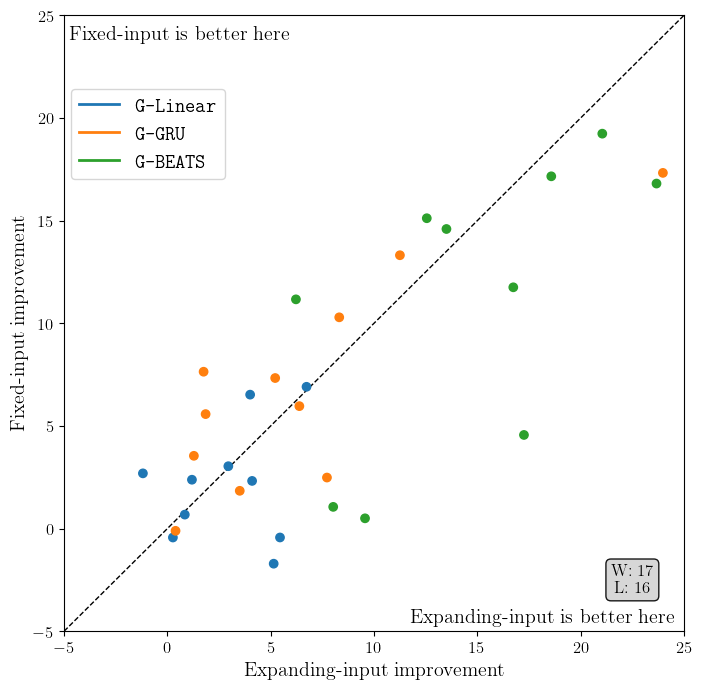

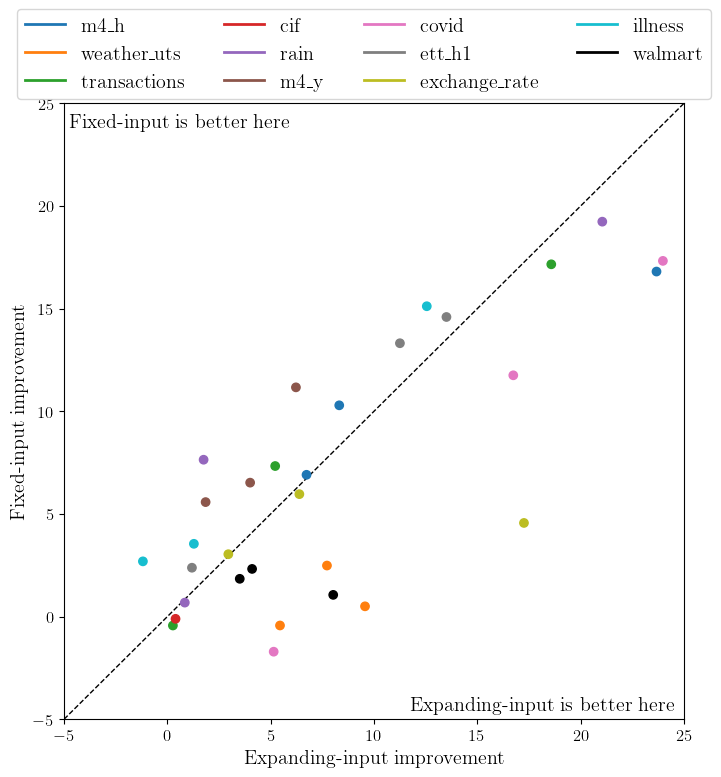

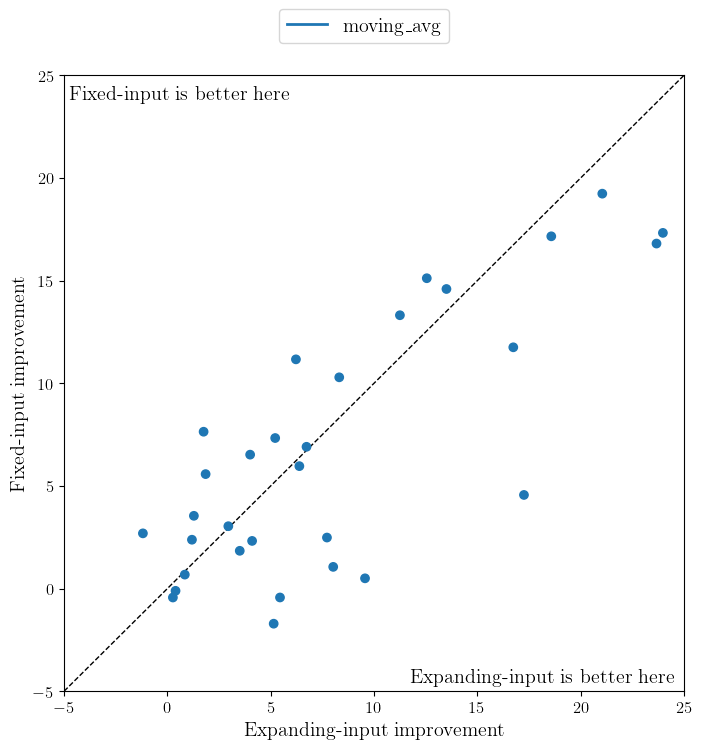

In [18]:
assert error_reduction_exp3.shape == error_reduction_exp4.shape

color_names = list(TABLEAU_COLORS.keys())
color_names.append("black")
color_names = np.array(color_names)

error_reduction_exp3 = np.nanmax(error_reduction_exp3,axis=-1,keepdims=True)
error_reduction_exp4 = np.nanmax(error_reduction_exp4,axis=-1,keepdims=True)

for color_axis in [0,1,2]:
    colors = color_names[np.arange(error_reduction_exp3.shape[color_axis])]
    if color_axis == 0:
        color = np.tile(colors, (error_reduction_exp3.shape[1], error_reduction_exp3.shape[2],1)).transpose(2,0,1)
    elif color_axis == 1:
        color = np.tile(colors, (error_reduction_exp3.shape[0], error_reduction_exp3.shape[2],1)).transpose(0,2,1)
    elif color_axis == 2:
        color = np.tile(colors, (error_reduction_exp3.shape[0], error_reduction_exp3.shape[1],1))

    filter_3 = ~np.isnan(error_reduction_exp3)
    filter_4 = ~np.isnan(error_reduction_exp4)
    improvement_3 = error_reduction_exp3[filter_3]
    improvement_4 = error_reduction_exp4[filter_4]
    color = color[filter_3]

    win_count_expanding = len(improvement_4[improvement_4 > improvement_3])
    tie_count_expanding = len(improvement_4[improvement_4 == improvement_3])
    loss_count_expanding = len(improvement_4[improvement_4 < improvement_3])
    print(win_count_expanding, tie_count_expanding, loss_count_expanding)

    fig, ax = plt.subplots(figsize=(8,8))

    ax.scatter(y=improvement_3, x=improvement_4, c=color)
    ax.set_xlabel("Expanding-input improvement", fontdict={"fontsize": "x-large"})
    ax.set_ylabel("Fixed-input improvement", fontdict={"fontsize": "x-large"})
    ax.tick_params(axis="both", labelsize="large")

    min_lim = -5
    max_lim = 25
    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)

    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], lw=1, linestyle="--", color="black",zorder=0)
    ax.text(x=ax.get_xlim()[1]*0.98, y=ax.get_ylim()[0]*0.95,s="Expanding-input is better here", ha="right", va="bottom", fontsize="x-large")
    ax.text(x=ax.get_xlim()[0]*0.95, y=ax.get_ylim()[1]*0.98,s="Fixed-input is better here", ha="left", va="top", fontsize="x-large")

    if color_axis == 0:
        legend_artists = dict(zip([format_algorithm_name(algo) for algo in c.algorithm_names_generic_input], [Line2D([0], [0], color=c, lw=2) for c in colors]))
        bbox_y = 0.8
        bbox_x = 0.23
        ncol = 1
        textbox_props = dict(boxstyle="round", edgecolor="black", facecolor="lightgrey", alpha=0.9)
        ax.text(
            max_lim*0.9, -2.5,
            f"W: {win_count_expanding}\nL: {loss_count_expanding}",
            fontsize=12,
            color="black",
            ha="center",
            va="center",
            bbox=textbox_props
        )
        figname = "generic_expanding_fixed_scatter_by_algo.pdf"
    elif color_axis == 1:
        legend_artists = dict(zip(c.dataset_names, [Line2D([0], [0], color=c, lw=2) for c in colors]))
        bbox_y = 1.01
        bbox_x = 0.5
        ncol = 4
        figname = "generic_expanding_fixed_scatter_by_dataset.pdf"
    elif color_axis == 2:
        legend_artists = dict(zip(c.decomp_input_names[1:], [Line2D([0], [0], color=c, lw=2) for c in colors]))
        bbox_y = 0.975
        bbox_x = 0.5
        ncol = 3
        figname = "generic_expanding_fixed_scatter_by_decomp.pdf"

    fig.legend(handles=list(legend_artists.values()), 
            labels=list(legend_artists.keys()), 
            ncol=ncol, 
            loc="upper center", 
            fontsize="x-large", 
            bbox_to_anchor=(bbox_x, bbox_y))
    fig.savefig("plots/"+figname,bbox_inches="tight")